In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import math

In [3]:
# data structure container
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # to store the intermidiate results of the bigger operation
        self._op = _op # to know which operation caused that intermidiate result
        self.label = label

    # representation container
    # if not defined then it will show memory location like <__main__.Value at 0x788a537fe810>
    def __repr__(self):
        return f"Value(data={self.data})"

    # arithmetic operation
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += (1 * output.grad)
            other.grad += (1 * output.grad)
        output._backward = _backward
        return output

    def __sub__(self, other): # self - other
        return self + (-other)

    def __neg__(self): # -self
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += (other.data * output.grad)
            other.grad += (self.data * output.grad)
        output._backward = _backward
        return output

    # fallback method to perform '3*a' kind of operation
    def __rmul__(self, other): # other * self
        return self*other

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supports int/floats"
        output = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * output.grad
        output._backward = _backward
        return output

    def __truediv__(self, other): # self / other
        # a/b = a * (b**-1)
        return self * (other ** -1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += ((1 - t**2) * out.grad)
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        output = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += (output.data * output.grad)
        output._backward = _backward
        return output

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v): # v --> root node
            # same as graph traversal logic
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
# visual representation to see the series of operations
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set() # set of all nodes and edges
    def build(v):
        if v not in nodes: # check each node
            nodes.add(v)
            # connect every child which involved 'v' for that operation 
            # and connect them with an edge
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': "LR"}) # left -> right (flow)

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n)) # for unique identification of each node
        # for any value in graph, create rectangular(record) node for it
        dot.node(name = uid, label="{ %s | data %.4f} | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation then create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
import torch
import random

In [6]:
class Neuron:
    def __init__(self, n_inputs):
        # initializing with random values
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # wx+b
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        output = activation.tanh()
        return output

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_inputs, n_output):
        # fully connected layer
        self.neurons = [Neuron(n_inputs) for _ in range(n_output)]

    def __call__(self, x):
        # perform activation operation for each neuron
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

In [7]:
class MLP:
    def __init__(self, n_inputs, n_outputs): # n_outs - list of size of layers in MLP
        sz = [n_inputs] + n_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [8]:
# x = [2.0, 3.0]
# n = Layer(4, 2)
# n(x)

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.26662966471739774)

In [9]:
len(n.parameters()) # ((3x4) +  3) + ((4x4) + 4) + ((4x1) + 1) 

41

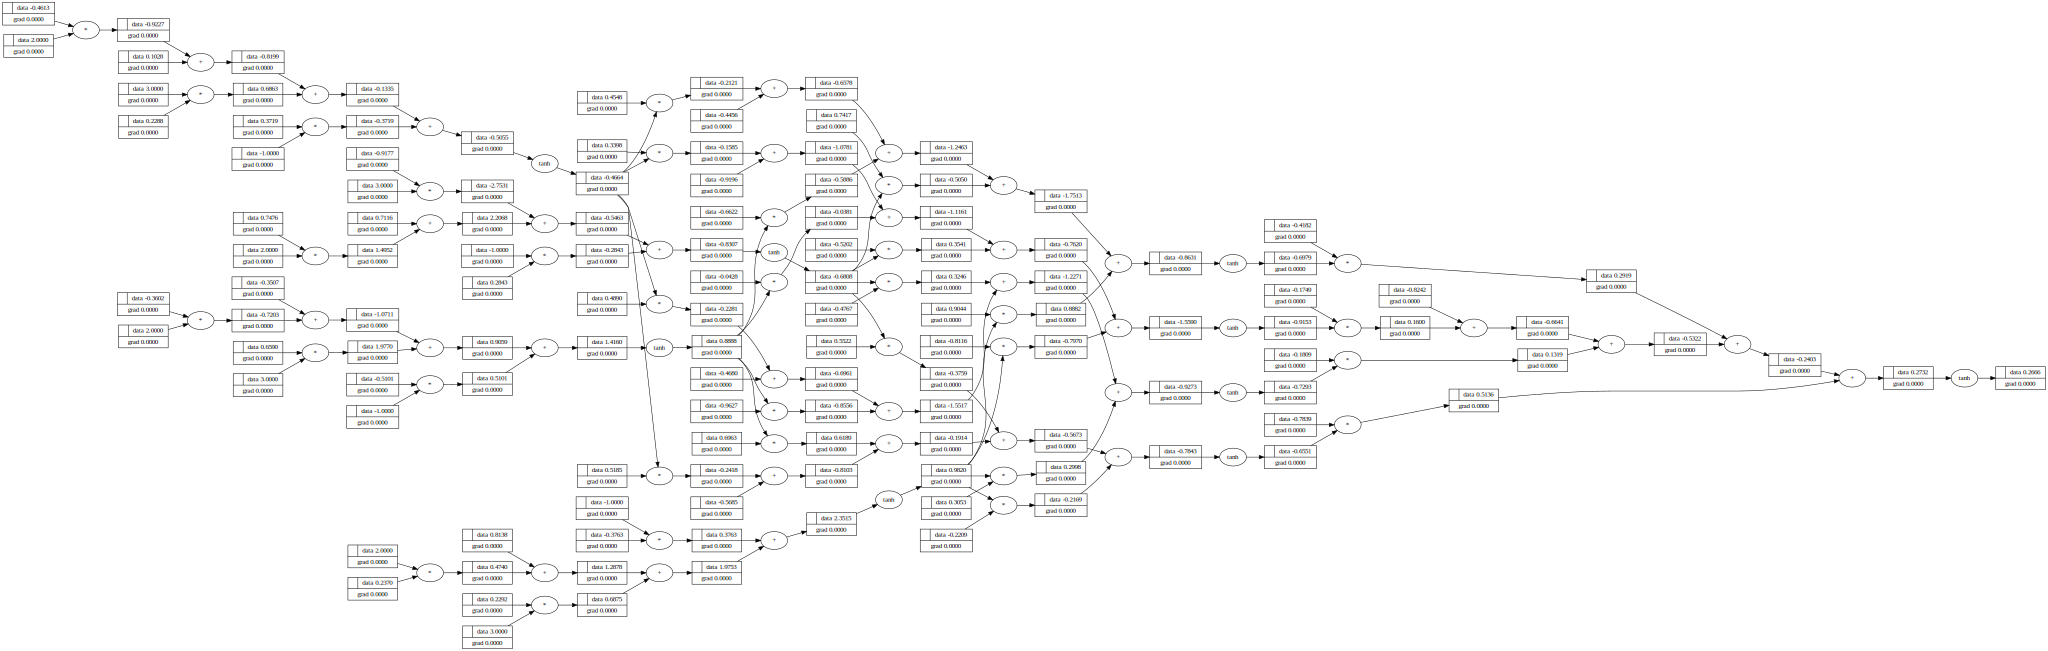

In [10]:
draw_dot(n(x))

In [11]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired output

y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.26662966471739774),
 Value(data=-0.2890141542507755),
 Value(data=-0.5498161812114398),
 Value(data=-0.14996592583402324)]

now the output which we have got is lot different our desired output. This is where the **loss** calculation gets into the picture. Which allows us to quantify the performance of a neural net on input data

In [12]:
# mean squared error loss (MSE)

loss = sum(((y_out - ygt)**2 for ygt, y_out in zip(ys, y_pred)), Value(0.0))
loss

Value(data=2.5684200228066096)

In [13]:
loss.backward()

In [14]:
n.layers[0].neurons[0].w[0].grad

1.388111897012851

In [15]:
n.layers[0].neurons[0].w[0].data

-0.46133313534758624

In [16]:
# gradient descent
for p in n.parameters():
    p.data += (-0.01 * p.grad)

In [17]:
n.layers[0].neurons[0].w[0].data

-0.47521425431771475

In [18]:
# again loss calc.
y_pred = [n(x) for x in xs]
loss = sum(((y_out - ygt)**2 for ygt, y_out in zip(ys, y_pred)), Value(0.0))
loss

Value(data=2.153472981223282)

as we can see the loss is decreased as intented after applying 1 iteration of gradient descent

In [19]:
# building an actual training loop
for k in range (15):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum(((y_out - ygt)**2 for ygt, y_out in zip(ys, y_pred)), Value(0.0))

    # backward pass
    # before that zero grad to prevent grad accumulation
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update grads
    # gradient descent
    for p in n.parameters():
        p.data += (-0.05 * p.grad)

    print(k, "loss: ", loss.data)
    

0 loss:  2.153472981223282
1 loss:  1.2316985990777043
2 loss:  0.7487216625048644
3 loss:  0.5042445280024688
4 loss:  0.367546271050209
5 loss:  0.28290293478134415
6 loss:  0.2268160766733763
7 loss:  0.18755949144016026
8 loss:  0.15885259739199883
9 loss:  0.13710857207799665
10 loss:  0.1201605264835344
11 loss:  0.10663523406011086
12 loss:  0.09562643674707813
13 loss:  0.08651506571579251
14 loss:  0.07886554828631649


In [20]:
y_pred

[Value(data=0.9029144919616388),
 Value(data=-0.8316131597212582),
 Value(data=-0.8911887826582725),
 Value(data=0.8289855461757615)]

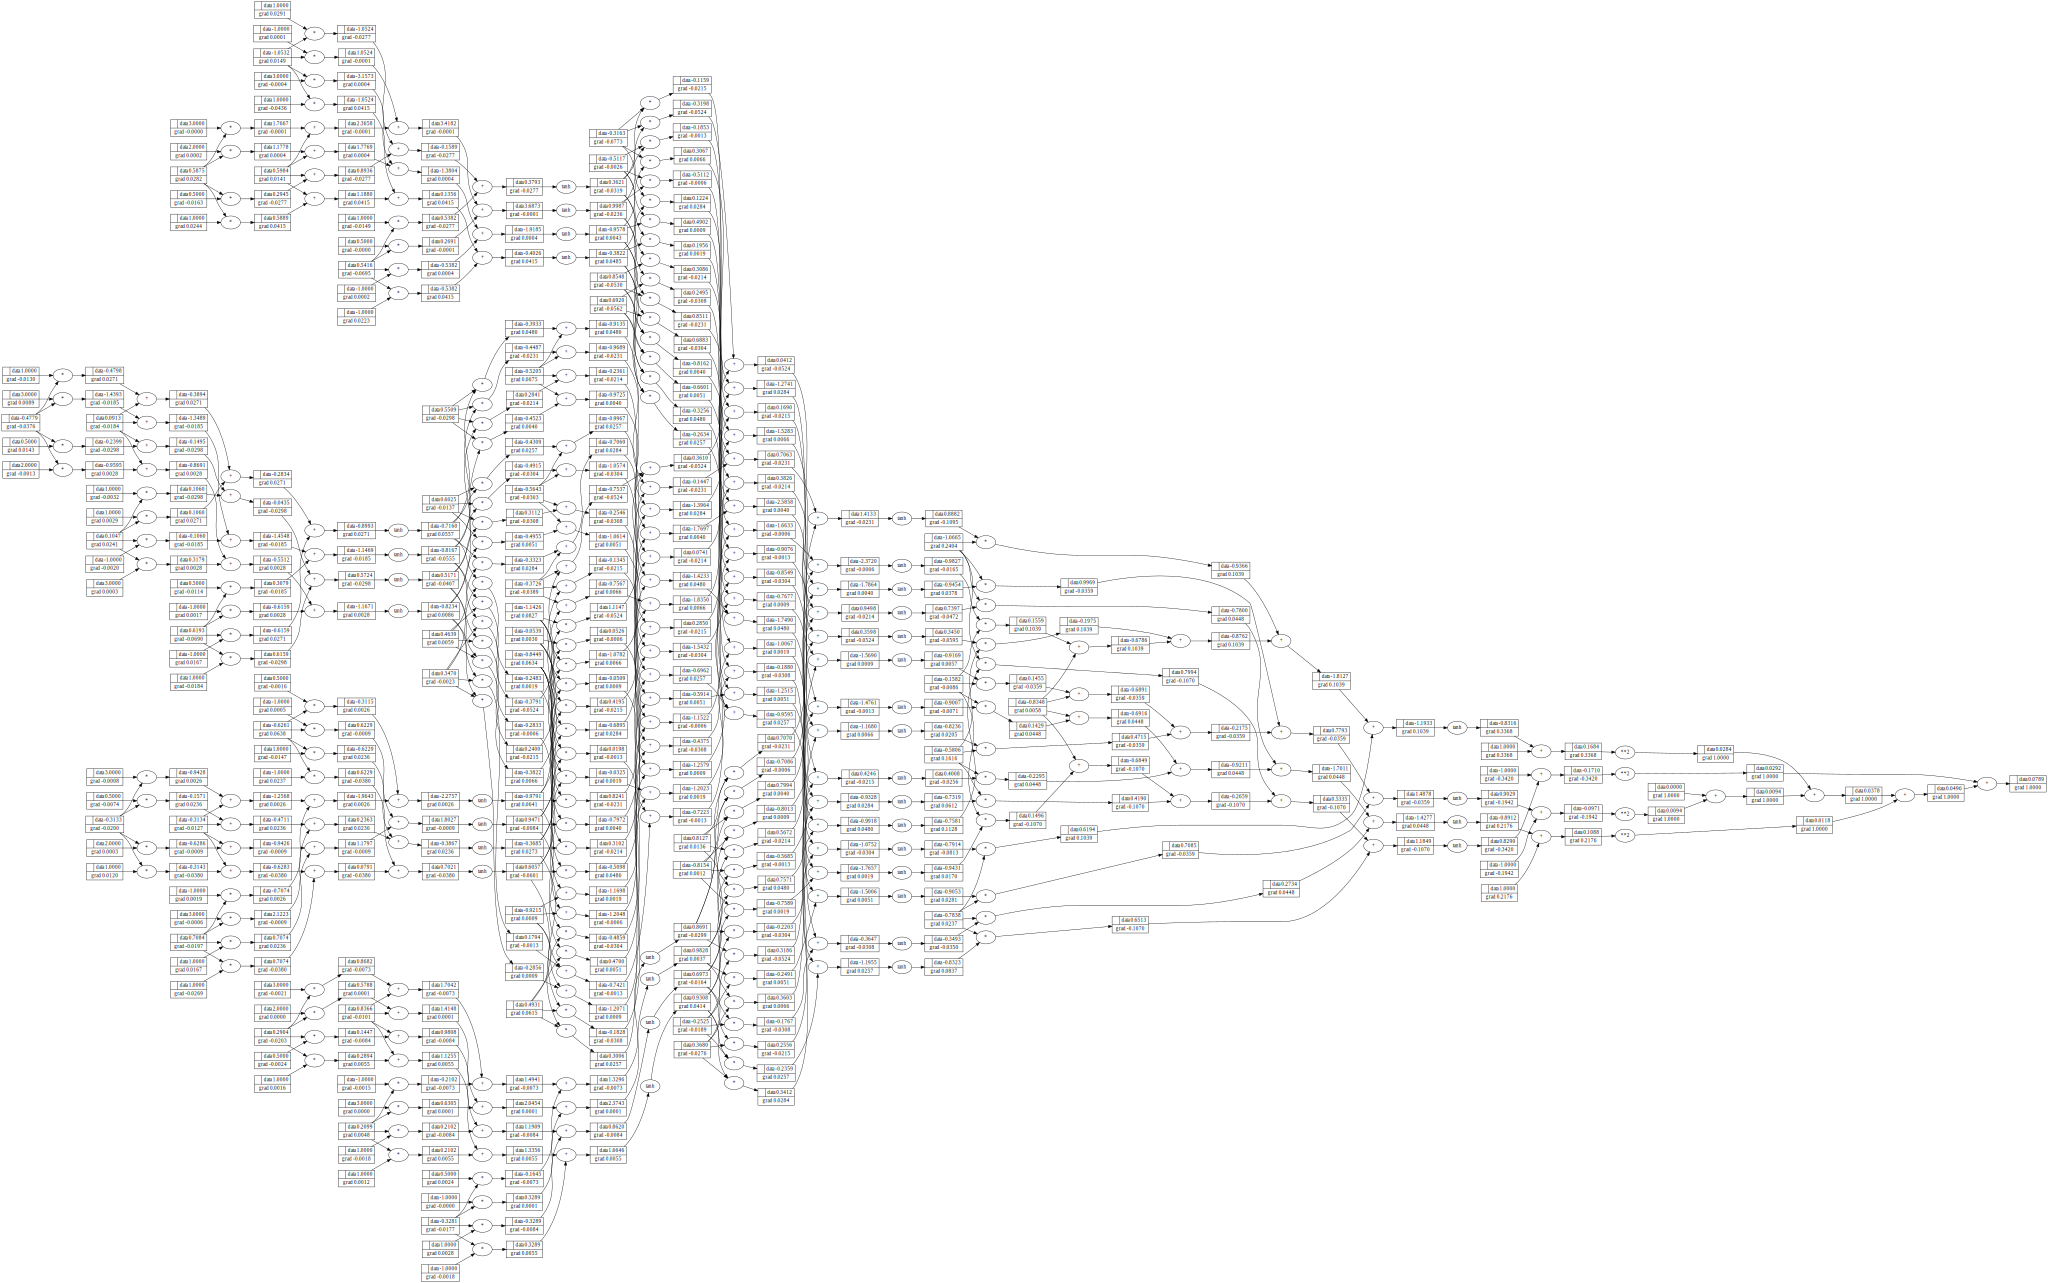

In [21]:
draw_dot(loss)